In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load dataset
data = pd.read_csv('cr_loan2.csv', na_values=' ')

# 1. Quick Inspection

In [3]:
# Check for null values
data.isnull().sum().sort_values(ascending=False)

loan_int_rate                 3116
person_emp_length              895
cb_person_cred_hist_length       0
cb_person_default_on_file        0
loan_percent_income              0
loan_status                      0
loan_amnt                        0
loan_grade                       0
loan_intent                      0
person_home_ownership            0
person_income                    0
person_age                       0
dtype: int64

In [4]:
# Get numerical and categorical features
cat_features = data.select_dtypes(include='object').columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list()
num_features.remove('loan_status') # drop target

# 2. Feature Engineering

**Imputing Null Values**

- Loan Interest Rate

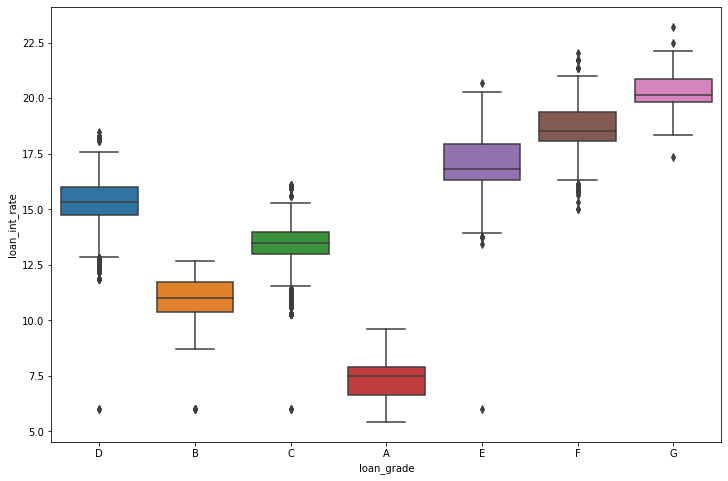

In [5]:
# Visualizing interest rate by grade
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='loan_grade', y='loan_int_rate', data=data, ax=ax)
plt.show()

As expected, loan grade correlates negatively with interest rate, i.e. higher grade lower interest rate. Thus, with this information, we could create imputation strategy of using the central tendancy of interest rate group by loan grade.

In [6]:
# Interest rate median value by loan grade
data.groupby('loan_grade')['loan_int_rate'].median()

loan_grade
A     7.490
B    10.990
C    13.480
D    15.310
E    16.820
F    18.535
G    20.160
Name: loan_int_rate, dtype: float64

In [7]:
# Filling null values with median value group by loan grade
data['loan_int_rate'] = data.groupby('loan_grade')['loan_int_rate'].apply(lambda x: x.fillna(x.median()))

- Person Employment Length

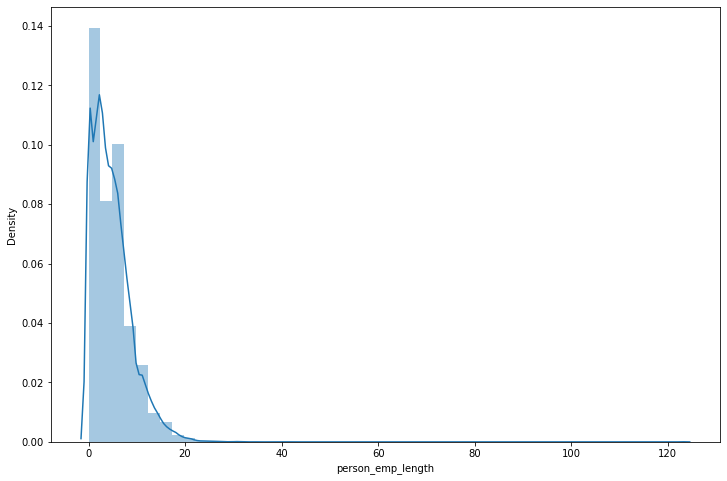

In [8]:
# Visualizing Person Employment Length distribution
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(data['person_emp_length'], ax=ax)
plt.show()

As we can see here, there are heavy outliers on person's employment length. It is quite impossible for a person to be employed for more than 60 years. Hence, I will drop any observations that has employement length >45 years (assuming they start working at 20 and retired at 65).

In [9]:
# Get outliers observations
indices_to_drop = data[data['person_emp_length']>45].index

# Remove the observations
data.drop(indices_to_drop, inplace=True)

Since person employment length is heavily skewed (positive), I will use the median value to impute the null.

In [10]:
# Impute person employment length
data['person_emp_length'].fillna(data['person_emp_length'].median(), inplace=True)

# 3. Data Preprocessing

- Data normalization for numerical features

In [11]:
data_or = data.copy()

In [12]:
from sklearn.preprocessing import StandardScaler

# Numerical scaling
data[num_features] = StandardScaler().fit_transform(data[num_features])

- One Hot Encoding for categorical features

In [13]:
# One Hot Encoding
data = pd.get_dummies(data)

In [14]:
# Preparing target and features
X = data.drop('loan_status',axis=1)
y = data['loan_status']

# 4. Model Training

- Splitting train and test dataset

In [15]:
from sklearn.model_selection import train_test_split

# Split dataset into 70/30 train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Logistic Regression** (Traditional Machine Learning)

In [16]:
from sklearn.linear_model import LogisticRegression

# Fit the model
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)

# Predict
y_proba_lr = clf_lr.predict_proba(X_test)[:,1]
y_preds_lr = clf_lr.predict(X_test)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Model evaluation function
def model_eval(X_test, y_test, y_preds, y_proba, model, model_name):
    # Classification report
    target_names = ['Non-Default', 'Default']
    print(classification_report(y_test, y_preds, target_names=target_names))
    
    # Confusion matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_preds), columns=['Predicted_0', 'Predicted_1'], 
                     index=['Actual_0', 'Actual_1'])
    print(cm)
    
    # Accuracy score
    acc = np.round(model.score(X_test, y_test), 3)
    print('\n')
    print('Accuracy score with {} is {}%'.format(model_name,(acc*100)))
    
    # Roc_auc_score
    auc = np.round(roc_auc_score(y_test, y_proba),3)
    print('\n')
    print('AUC score with {} is {}'.format(model_name, auc))

In [18]:
# Logistic Regression model evaluation
model_eval(X_test, y_test, y_preds_lr, y_proba_lr, clf_lr, 'Logistic Regression')

              precision    recall  f1-score   support

 Non-Default       0.89      0.95      0.92      7617
     Default       0.78      0.57      0.66      2157

    accuracy                           0.87      9774
   macro avg       0.83      0.76      0.79      9774
weighted avg       0.86      0.87      0.86      9774

          Predicted_0  Predicted_1
Actual_0         7263          354
Actual_1          934         1223


Accuracy score with Logistic Regression is 86.8%


AUC score with Logistic Regression is 0.874


From the evaluation we can derive three insights:
- accuracy seems good, but it's quite useless since we have imbalance dataset (natural accuracy = 78%)
- 57% of default credits were correctly detected
- 934 credits that predicted as non-default but actually default

**Random Forest Classifier** (Modern Machine Learning)

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Fit the model
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

# Predict
y_proba_rf = clf_rf.predict_proba(X_test)[:,1]
y_preds_rf = clf_rf.predict(X_test)

In [20]:
# Random Forest Classifier model evaluation
model_eval(X_test, y_test, y_preds_rf, y_proba_rf, clf_rf, 'Random Forest')

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      7617
     Default       0.97      0.72      0.83      2157

    accuracy                           0.93      9774
   macro avg       0.95      0.86      0.89      9774
weighted avg       0.94      0.93      0.93      9774

          Predicted_0  Predicted_1
Actual_0         7572           45
Actual_1          597         1560


Accuracy score with Random Forest is 93.4%


AUC score with Random Forest is 0.934


We can see right away that the Random Forrest Classifier outperform the Logistic Regression for all of the metrics.

Let's try other classifier.

**Support Vector Machine (SVM) Classifier** (Modern Machine Learning)

In [21]:
from sklearn.svm import SVC

# Fit the model
clf_svc = SVC(probability=True)
clf_svc.fit(X_train, y_train)

# Predict
y_proba_svc = clf_svc.predict_proba(X_test)[:,1]
y_preds_svc = clf_svc.predict(X_test)

In [22]:
# Support Vector Machine Classifier model evaluation
model_eval(X_test, y_test, y_preds_svc, y_proba_svc, clf_svc, 'SVC')

              precision    recall  f1-score   support

 Non-Default       0.91      0.99      0.95      7617
     Default       0.94      0.66      0.77      2157

    accuracy                           0.92      9774
   macro avg       0.93      0.82      0.86      9774
weighted avg       0.92      0.92      0.91      9774

          Predicted_0  Predicted_1
Actual_0         7531           86
Actual_1          744         1413


Accuracy score with SVC is 91.5%


AUC score with SVC is 0.903


**Neural Networks** (Deep Learning)

In [23]:
from sklearn.neural_network import MLPClassifier

# Fit the model
clf_nn = MLPClassifier()
clf_nn.fit(X_train, y_train)

# Predict
y_proba_nn = clf_nn.predict_proba(X_test)[:,1]
y_preds_nn = clf_nn.predict(X_test)

In [24]:
# Neural Networks model evaluation
model_eval(X_test, y_test, y_preds_nn, y_proba_nn, clf_nn, 'Neural Networks')

              precision    recall  f1-score   support

 Non-Default       0.92      0.99      0.95      7617
     Default       0.94      0.71      0.81      2157

    accuracy                           0.93      9774
   macro avg       0.93      0.85      0.88      9774
weighted avg       0.93      0.93      0.92      9774

          Predicted_0  Predicted_1
Actual_0         7519           98
Actual_1          630         1527


Accuracy score with Neural Networks is 92.60000000000001%


AUC score with Neural Networks is 0.924


# 5. Plotting Decision Boundaries

In [25]:
from sklearn.decomposition import PCA

# Dimension reduction
pca = PCA(n_components=2)
X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.fit_transform(X_test)

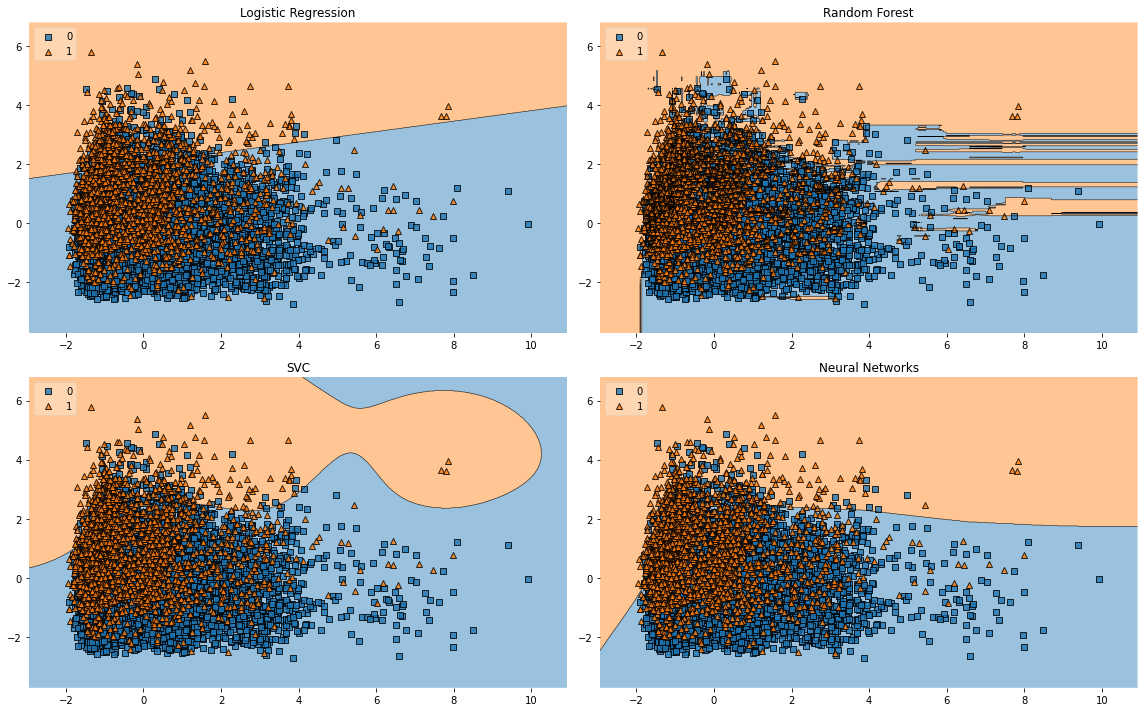

In [26]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

# Re-instate Models
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)
clf4 = MLPClassifier(random_state=0)

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(16, 10))

labels = ['Logistic Regression',
          'Random Forest',
          'SVC',
          'Neural Networks']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):
    clf.fit(X_test_transformed, y_test)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_test_transformed, y=y_test.to_numpy(),
                                clf=clf, legend=2)
    plt.title(lab)

plt.tight_layout()
#plt.savefig('decision_boundaries.png', dpi=500, format='png')
plt.show()

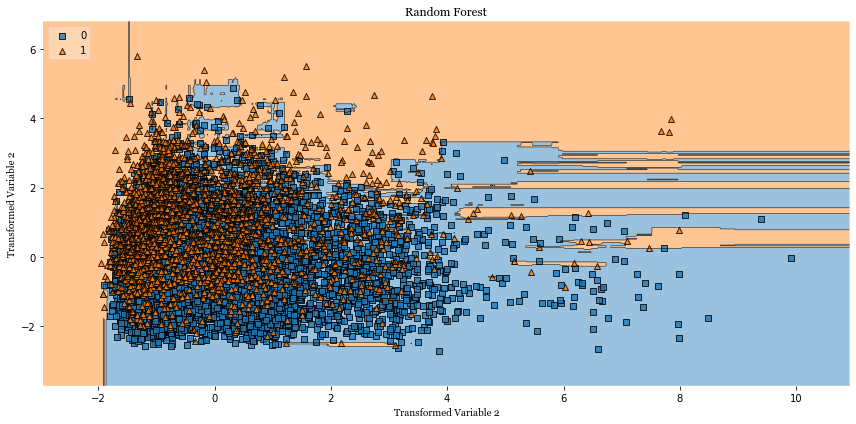

In [27]:
# Decision Boundary focus on Random Forest
plt.figure(figsize=(12,6))
clf2.fit(X_test_transformed, y_test)
fig = plot_decision_regions(X=X_test_transformed, y=y_test.to_numpy(),
                                clf=clf2, legend=2)

plt.title("Random Forest", fontname='Georgia')
plt.ylabel('Transformed Variable 2', fontname='Georgia')
plt.xlabel('Transformed Variable 2', fontname='Georgia')
plt.tight_layout()
#plt.savefig('rf_db.png', dpi=400, format='png')
plt.show()

# 6. ROC Curve

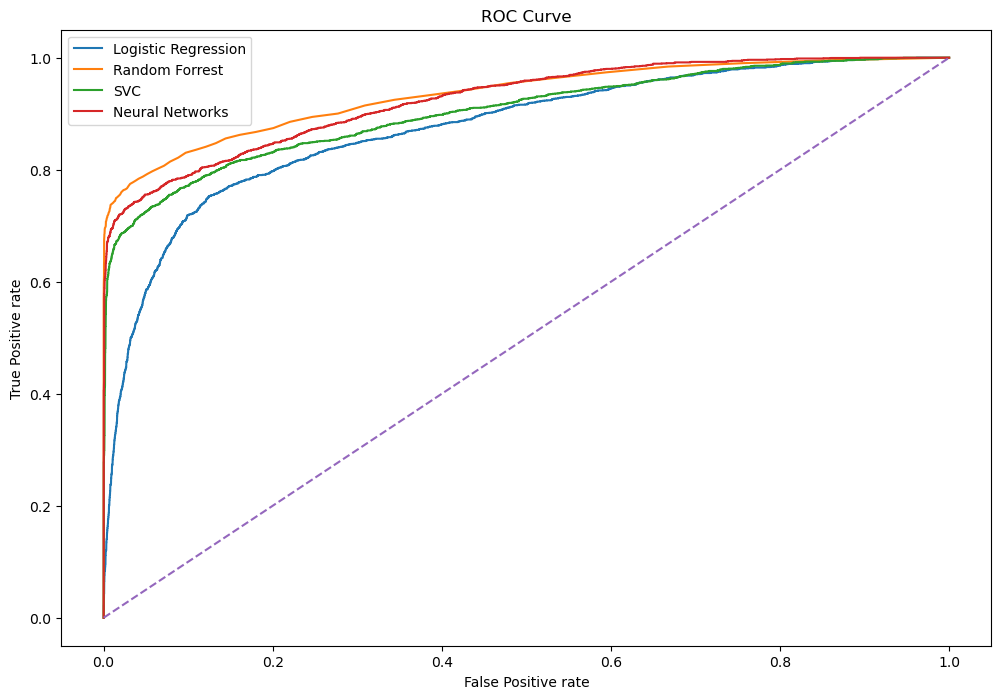

In [28]:
from sklearn.metrics import roc_curve
plt.style.use('default')

# Get false positive rate & false positive rate
fpr_lr, tpr_lr, treshold = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, treshold = roc_curve(y_test, y_proba_rf)
fpr_svc, tpr_svc, treshold = roc_curve(y_test, y_proba_svc)
fpr_nn, tpr_nn, treshold = roc_curve(y_test, y_proba_nn)

# Visualize ROC
plt.figure(figsize=(12,8))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forrest')
plt.plot(fpr_svc, tpr_svc, label='SVC')
plt.plot(fpr_nn, tpr_nn, label='Neural Networks')
plt.plot([0,1], [0,1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()
#plt.savefig('roc_curve.png', dpi=500, format='png')
plt.show()

# 7. Findings Table

- Accuracy
- AUC
- Number of true predicted defaults
- Recall (number of true predicted defaults / number of actual defaults)
- Loss avoidance

In [29]:
# Accuracy score
acc_lr = np.round(clf_lr.score(X_test, y_test), 3) * 100
acc_rf = np.round(clf_rf.score(X_test, y_test), 3) * 100
acc_svc = np.round(clf_svc.score(X_test, y_test), 3) * 100
acc_nn = np.round(clf_nn.score(X_test, y_test), 3) * 100

In [30]:
# AUC 
auc_lr = np.round(roc_auc_score(y_test, y_proba_lr),3) * 100
auc_rf = np.round(roc_auc_score(y_test, y_proba_rf),3) * 100
auc_svc = np.round(roc_auc_score(y_test, y_proba_svc),3) * 100
auc_nn = np.round(roc_auc_score(y_test, y_proba_nn),3) * 100

In [31]:
# Number of true predicted results
true_def_lr = confusion_matrix(y_test, y_preds_lr)[1,1]
true_def_rf = confusion_matrix(y_test, y_preds_rf)[1,1]
true_def_svc = confusion_matrix(y_test, y_preds_svc)[1,1]
true_def_nn = confusion_matrix(y_test, y_preds_nn)[1,1]

In [32]:
# Table
df_result = pd.DataFrame({'Accuracy':[acc_lr, acc_rf, acc_svc, acc_nn],
                         'AUC':[auc_lr, auc_rf, auc_svc, auc_nn],
                         '# of True Predicted Defaults':[true_def_lr, true_def_rf, true_def_svc, true_def_nn]},
                        index=['Logistic Regression', 'Random Forest',
                              'SVC', 'Neural Networks'])

# Recall
df_result['Recall'] = np.round(df_result['# of True Predicted Defaults'] / y_test.sum(),3) * 100

# Actual Loss
X_test_unscaled = data_or.loc[X_test.index]
actual_loss = X_test_unscaled[X_test_unscaled['loan_status']==1]['loan_amnt'].sum()
df_result['Actual Loss'] = [actual_loss]*4

# Loss Avoidance
df_result['Loss Avoidance'] = ((df_result['Recall']/100) * df_result['Actual Loss']).astype('int')

In [33]:
df_result

,Accuracy,AUC,# of True Predicted Defaults,Recall,Actual Loss,Loss Avoidance
Logistic Regression,86.8,87.4,1223,56.7,23310375,13216982
Random Forest,93.4,93.4,1560,72.3,23310375,16853401
SVC,91.5,90.3,1413,65.5,23310375,15268295
Neural Networks,92.6,92.4,1527,70.8,23310375,16503745


# Advance Tuning

**Imbalance with SMOTE**

In [34]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 

# Generate SMOTE on training set
sm = SMOTEENN(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [35]:
# Fit the resampled RF
clf_rf_res = RandomForestClassifier()
clf_rf_res.fit(X_train_res, y_train_res)

# Predict
y_proba_rf_res = clf_rf_res.predict_proba(X_test)[:,1]
y_preds_rf_res = clf_rf_res.predict(X_test)

In [36]:
# Resampled RF model evaluation
model_eval(X_test, y_test, y_preds_rf_res, y_proba_rf_res, clf_rf_res, 'Resampled RF')

              precision    recall  f1-score   support

 Non-Default       0.94      0.93      0.93      7617
     Default       0.75      0.79      0.77      2157

    accuracy                           0.89      9774
   macro avg       0.84      0.86      0.85      9774
weighted avg       0.90      0.89      0.90      9774

          Predicted_0  Predicted_1
Actual_0         7050          567
Actual_1          462         1695


Accuracy score with Resampled RF is 89.5%


AUC score with Resampled RF is 0.925


# Acceptance Rate

In [37]:
# Function for bad rate
def bad_rate(y_test, y_proba, list_of_acc_rate):
    bad_rate = []
    df_preds = pd.DataFrame({'Actual':y_test,'Proba':y_proba})
    
    for acc_rate in list_of_acc_rate:
        # Percentile rate
        perc = np.quantile(y_proba, acc_rate)

        # Prediction w/ x% acceptance rate
        df_preds['Predicted'] = df_preds['Proba'].apply(lambda x : 1 if x >= perc else 0)

        # Predicted credits to be non-default
        non_def_predicted = df_preds[df_preds['Predicted']==0]

        # Bad rate (number of credits predicted to be non-default but actually default)
        bad_rate.append(np.round(non_def_predicted['Actual'].sum() / len(non_def_predicted),3) * 100)
        
    return bad_rate

In [38]:
list_bad_rate = bad_rate(y_test, y_proba_rf, np.linspace(0,1,21))

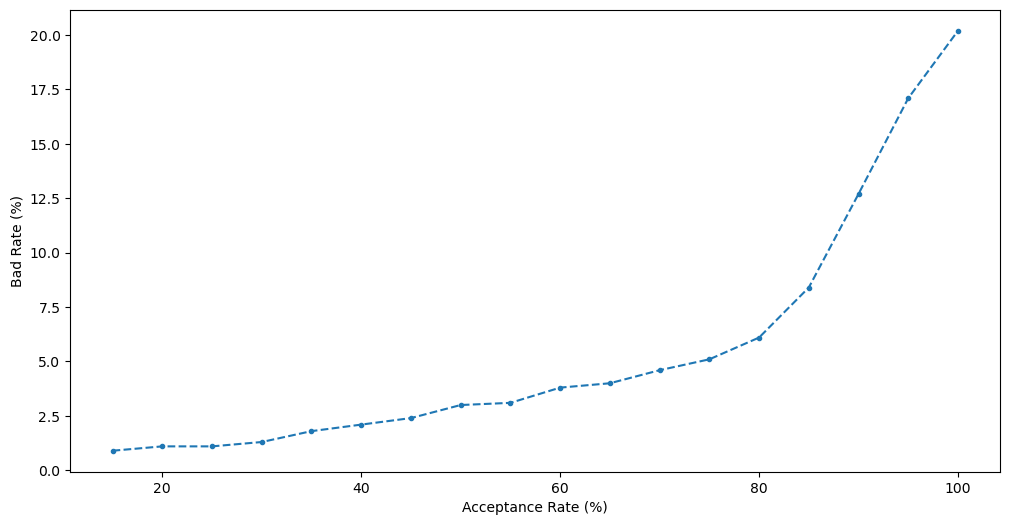

In [39]:
# Visualize bad rate
plt.figure(figsize=(12,6))
plt.plot(np.linspace(0,1,21)*100, list_bad_rate, linestyle='--', marker='.')
plt.xlabel('Acceptance Rate (%)')
plt.ylabel('Bad Rate (%)')
plt.show()

# Expected Loss

In [40]:
# PD Table with Loan Amount
df_el = pd.DataFrame({'Proba_lr':y_proba_lr, 'Proba_rf':y_proba_rf, 'Proba_svc':y_proba_svc,
                     'Proba_nn':y_proba_nn, 'Loan':data_or.loc[X_test.index]['loan_amnt']})

In [41]:
expected_loss = []
for clf in ['lr', 'rf', 'svc', 'nn']:
    df_el['E(Loss)_'+clf] = df_el['Proba_'+clf] * df_el['Loan']
    print('Expected Loss for {} classifier is $ {}'.format(clf, int(np.round(df_el['E(Loss)_'+clf].sum()))))
    expected_loss.append(int(np.round(df_el['E(Loss)_'+clf].sum())))

Expected Loss for lr classifier is $ 22879662
Expected Loss for rf classifier is $ 23238528
Expected Loss for svc classifier is $ 23397838
Expected Loss for nn classifier is $ 22435291


In [42]:
# Actual Loss 
print('Actual Loss of Credits Default is $ {}'.format(df_result['Actual Loss'][0]))

Actual Loss of Credits Default is $ 23310375


In [43]:
# Append Expected Loss with respect to each classifiers
df_result['Expected Loss'] = expected_loss

# Difference between Actual Loss in Expected Loss
df_result['Diff Loss'] = df_result['Actual Loss'] - df_result['Expected Loss']

In [44]:
df_result

,Accuracy,AUC,# of True Predicted Defaults,Recall,Actual Loss,Loss Avoidance,Expected Loss,Diff Loss
Logistic Regression,86.8,87.4,1223,56.7,23310375,13216982,22879662,430713
Random Forest,93.4,93.4,1560,72.3,23310375,16853401,23238528,71847
SVC,91.5,90.3,1413,65.5,23310375,15268295,23397838,-87463
Neural Networks,92.6,92.4,1527,70.8,23310375,16503745,22435291,875084


# Feature Importances

**Logistic Regression & Random Forest**

In [45]:
# LR & RF important features
lr_importance = clf_lr.coef_[0]
rf_importance = clf_rf.feature_importances_

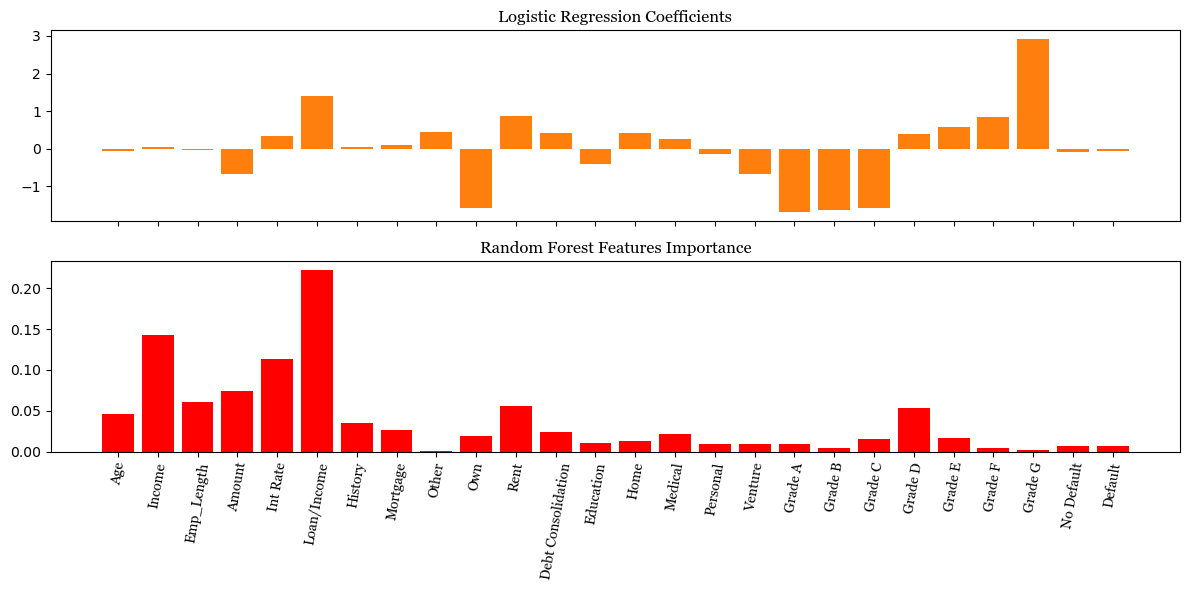

In [46]:
labels_importance = ['Age', 'Income', 'Emp_Length', 'Amount', 'Int Rate', 'Loan/Income', 'History', 'Mortgage',
                    'Other', 'Own', 'Rent', 'Debt Consolidation', 'Education', 'Home', 'Medical', 'Personal',
                    'Venture', 'Grade A', 'Grade B', 'Grade C', 'Grade D', 'Grade E', 'Grade F','Grade G',
                     'No Default','Default']
fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)

ax[0].bar(labels_importance, lr_importance, color='tab:orange')
ax[0].set_title('Logistic Regression Coefficients', fontname='Georgia')

ax[1].bar(labels_importance, rf_importance, color='r')
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=80, fontname='Georgia')
ax[1].set_title('Random Forest Features Importance', fontname='Georgia')

fig.tight_layout()
#plt.savefig('importance.png', dpi=400, format='png')
plt.show()

# Indonesian Credit

In [47]:
# Load Indonesian outstanding credit dataset
indo_credit = pd.read_excel('Indonesian_Credit.xlsx', index_col=0)
indo_credit = indo_credit.T

In [48]:
# Date index
indo_credit.index = pd.date_range(start='2010-01', end='2020-12', freq='M')

# Trillion unit
indo_credit = indo_credit / 1000

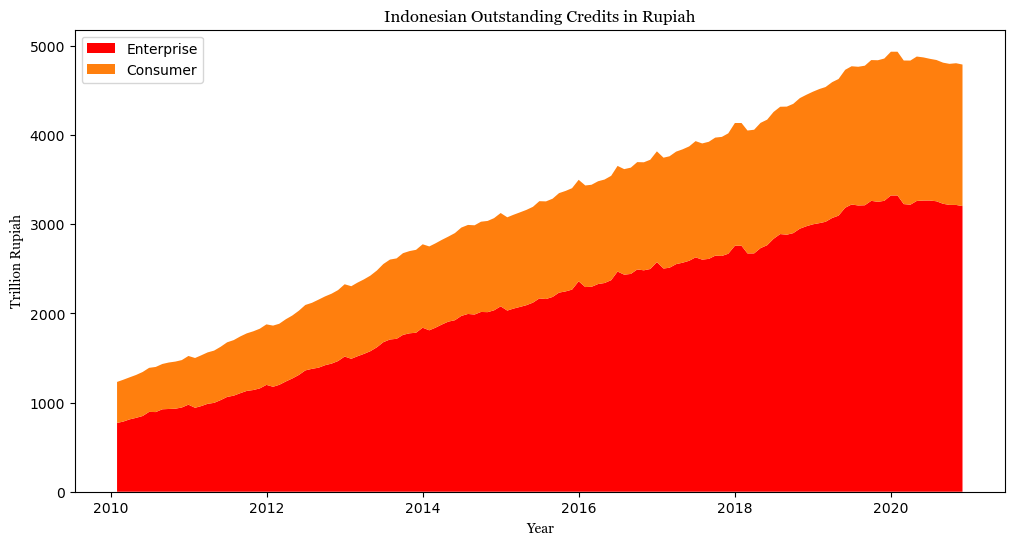

In [49]:
# Visualize Area plot
plt.figure(figsize=(12,6))
plt.stackplot(indo_credit.index, indo_credit['Enterprise_Credit'], indo_credit['Consumer_Credit'], 
              labels=['Enterprise', 'Consumer'], colors=['r', 'tab:orange'])
plt.title('Indonesian Outstanding Credits in Rupiah', fontname='Georgia')
plt.xlabel('Year', fontname='Georgia')
plt.ylabel('Trillion Rupiah', fontname='Georgia')
plt.legend(loc='upper left')
#plt.savefig('credit_market.png', dpi=400, format='png')
plt.show()

# Recall and Accuracy metrics

In [50]:
# Convert into integer
df_result['Recall'] = df_result['Recall'].astype('int')
df_result['Accuracy'] = df_result['Accuracy'].astype('int')

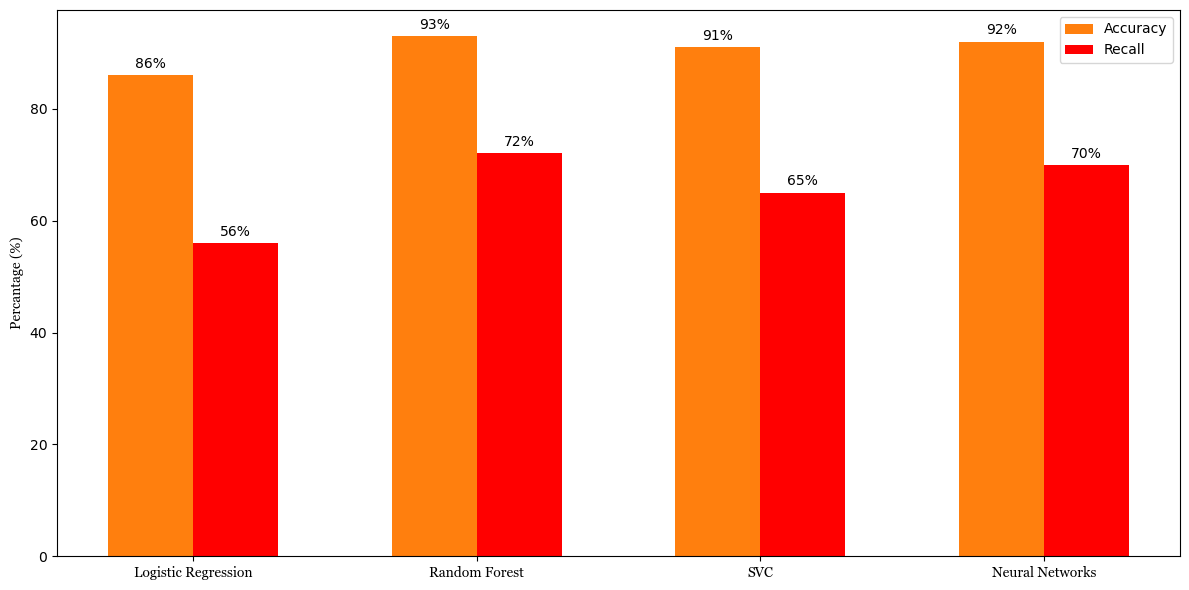

In [51]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('default')

# Visualize 
labels = df_result.index
acc = df_result['Accuracy']
rec = df_result['Recall']

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, acc, width, label='Accuracy', color='tab:orange')
rects2 = ax.bar(x + width/2, rec, width, label='Recall', color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percantage (%)', fontname='Georgia')
#ax.set_title('Accuracy and Recall by Classifiers')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontname='Georgia')
ax.legend(loc='upper right')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
#plt.savefig('acc_recall.png', dpi=300, format='png' )
plt.show()

In [52]:
df_result

,Accuracy,AUC,# of True Predicted Defaults,Recall,Actual Loss,Loss Avoidance,Expected Loss,Diff Loss
Logistic Regression,86,87.4,1223,56,23310375,13216982,22879662,430713
Random Forest,93,93.4,1560,72,23310375,16853401,23238528,71847
SVC,91,90.3,1413,65,23310375,15268295,23397838,-87463
Neural Networks,92,92.4,1527,70,23310375,16503745,22435291,875084


# Loss Avoidance

In [53]:
df_result['Loss Occurred'] = df_result['Actual Loss'] - df_result['Loss Avoidance']

In [54]:
stack_bar = pd.concat([df_result['Loss Avoidance'], df_result['Loss Occurred']], axis=1)/1000000
stack_bar.rename(columns={'Loss Occurred':'Loss Occurred', 'Loss Avoidance':'Loss Avoided'}, inplace=True)

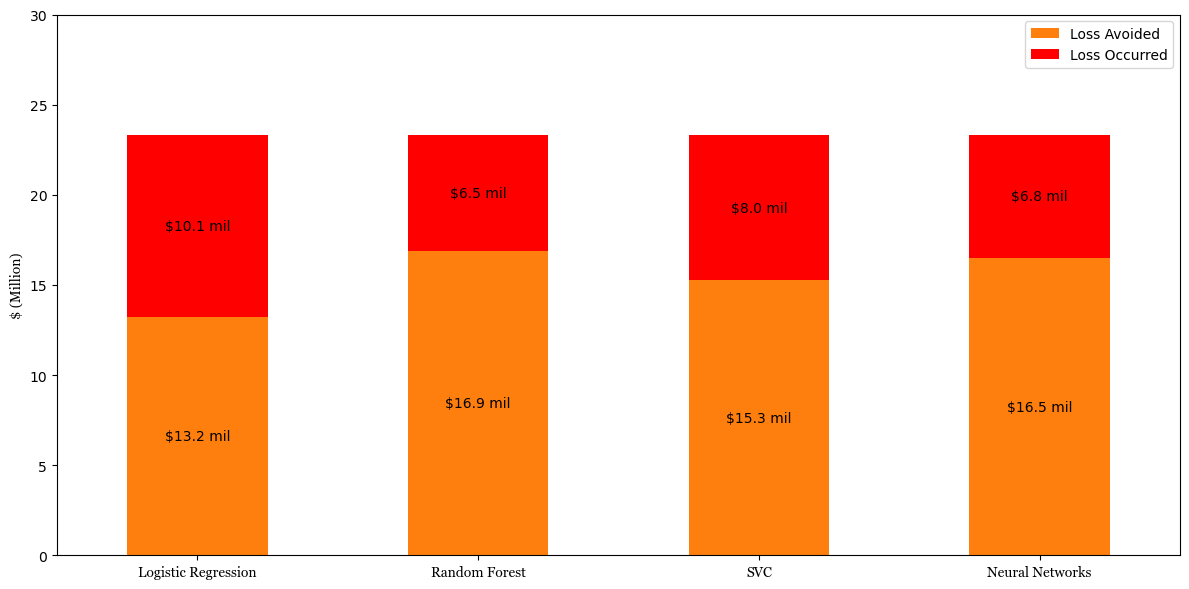

In [55]:
ax = stack_bar.plot.bar(stacked=True, width=0.5, color=['tab:orange', 'r'], figsize=(12,6))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '${:.1f} mil'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.set_ylim(top=30)
ax.set_xticklabels(labels, rotation = 0, fontname='Georgia')
ax.set_ylabel('$ (Million)', fontname='Georgia')

plt.tight_layout()
#plt.savefig('stack_bar.png', dpi=400, format='png')
plt.show()

# Delta Expected Loss

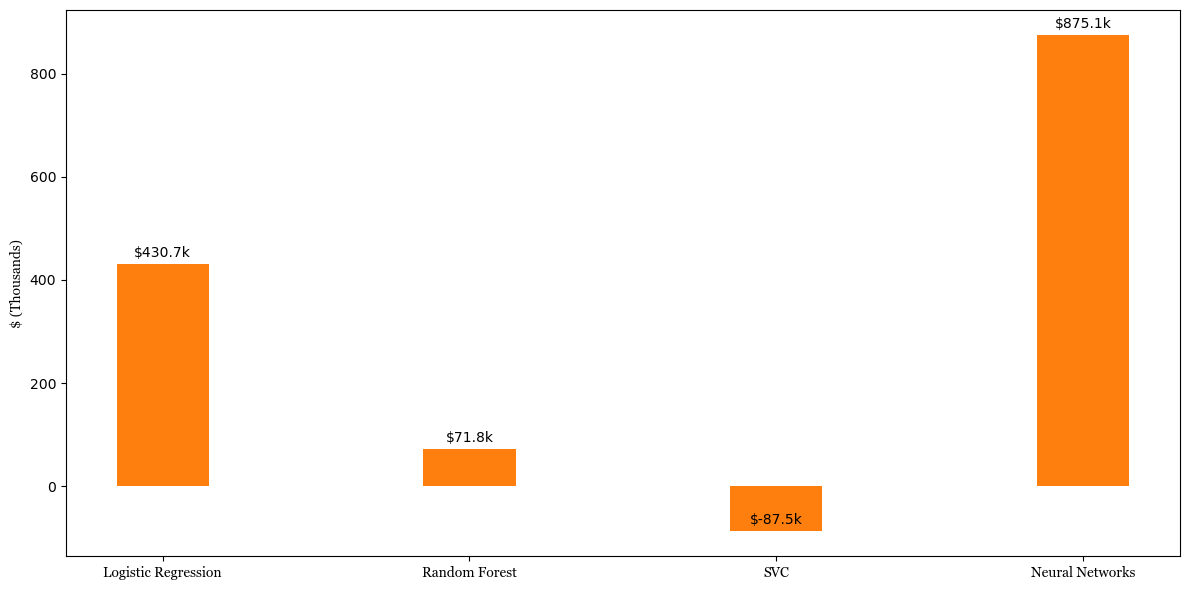

In [56]:
# Visualize differences between expected loss and actual loss

fig, ax = plt.subplots(figsize=(12,6))
rects = ax.bar(df_result.index, np.round(df_result['Diff Loss']/1000,1), width=0.3, color='tab:orange')

ax.set_ylabel('$ (Thousands)', fontname='Georgia')
ax.set_xticklabels(labels, fontname='Georgia')

def autolabel1(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('${}k'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel1(rects)

fig.tight_layout()
plt.savefig('expected_loss.png', dpi=400, format='png')
plt.show()

# PCA Visualize

In [57]:
# Dataframe of two-transformed variables
test_trans = pd.DataFrame({'var_1':X_test_transformed[:,0], 'var_2':X_test_transformed[:,1], 'Actual':y_test})

In [58]:
# Seperate both default and non-default
test_trans_0 = test_trans[test_trans['Actual']==0]
test_trans_1 = test_trans[test_trans['Actual']==1]

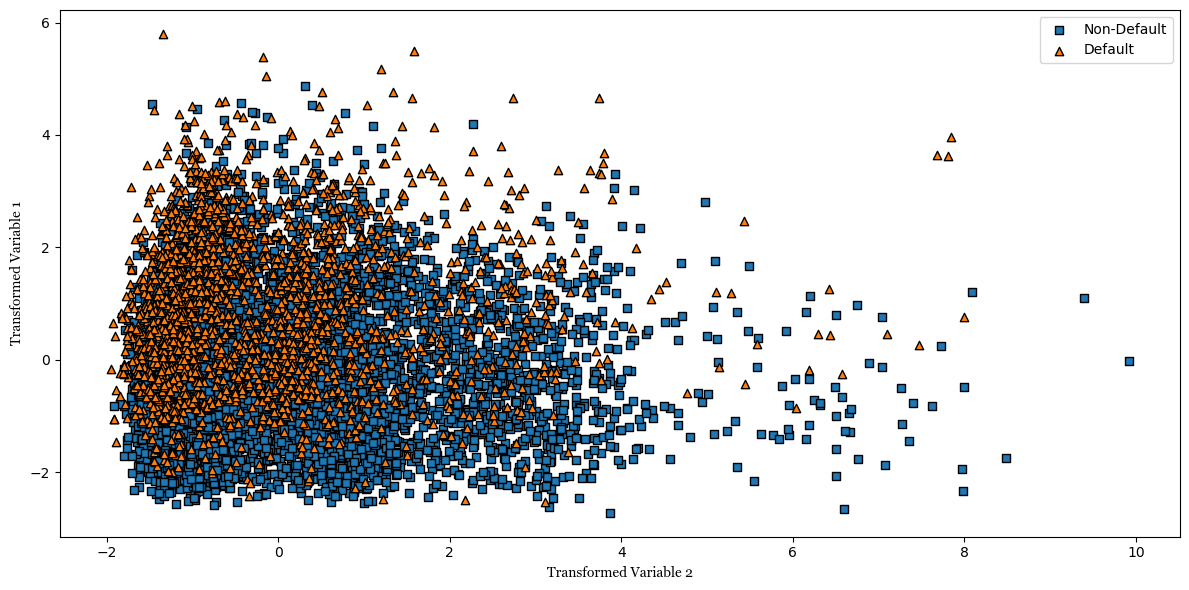

In [59]:
# Visualize 
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(test_trans_0['var_1'], test_trans_0['var_2'], marker='s', label='Non-Default', edgecolor='k')
ax.scatter(test_trans_1['var_1'], test_trans_1['var_2'], marker='^', color='tab:orange', edgecolor='k', label='Default')
ax.legend()
ax.set_ylabel('Transformed Variable 1', fontname='Georgia')
ax.set_xlabel('Transformed Variable 2', fontname='Georgia')

fig.tight_layout()
plt.savefig('pca.png', dpi=400, format='png')
plt.show()